# Policy Optimization

Here we show a simple policy optimization example using the `NNPolicy` and the `FirstOrderNNPolicyOptimizer`. 

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from score_po.policy_optimizer import (
    PolicyOptimizerParams,
    FirstOrderNNPolicyOptimizer)
from score_po.dynamical_system import DynamicalSystem
from score_po.costs import QuadraticCost
from score_po.policy import NNPolicy
from score_po.nn import MLP

We'll define the parameters first, which includes the horizon, batch size, rate, etc. 
We will use `params.x0_upper` and `params.x0_lower` as limits of a uniform distribution.

In [10]:
params = PolicyOptimizerParams()
params.T = 20
params.x0_upper = torch.Tensor([0.5, 0.5])
params.x0_lower = -torch.Tensor([0.5, 0.5])
params.batch_size = 512
params.std = 1e-2
params.lr = 1e-8
params.max_iters = 200

Now we'll set up the dynamical system. We will choose the simple system of $f(x,u) = x + u$. To define this system, you'll need to make your own `DynamicalSystem` class and pass it onto `params`.

In [11]:
# 1. Set up dynamical system.
class SingleIntegrator(DynamicalSystem):
    def __init__(self):
        super().__init__(2, 2)
        self.is_differentiable = True

    def dynamics(self, x, u):
        return x + u

    def dynamics_batch(self, x_batch, u_batch):
        return x_batch + u_batch


dynamics = SingleIntegrator()
params.dynamical_system = dynamics


Then set up the cost function. Here we will use the quadartic cost 
$c_d(x_{T+1}) + \sum^{i=0}_{T} c(x_t, u_t)$ where 
$c_d(x) = (x-x_d)^\intercal \mathbf{Q}_d (x - x_d)$ and $c(x,u) = (x - x_d)^\intercal \mathbf{Q} (x - x_d) + u^\intercal \mathbf{R} u$.

In [12]:
# 2. Set up cost.
Q = torch.eye(2)
R = 1e-1 * torch.eye(2)
Qd = 100 * params.T * torch.eye(2)
xd = torch.zeros(2)
cost = QuadraticCost(Q, R, Qd, xd)
params.cost = cost

Finall choose a policy class. We'll choose a neural network policy $u_t = \pi(x_t, \theta)$.

In [13]:
# 3. Set up policy and initial guess.
network = MLP(2, 2, [128, 128])
policy = NNPolicy(2, 2, network)
params.policy = policy
params.policy_params_0 = policy.get_parameters()


Now we can solve our problem, and visualize our trajectory. 

Iteration: 0000 | Cost: 3504.017 | Time: 0.000
Iteration: 0001 | Cost: 3111.965 | Time: 0.599
Iteration: 0002 | Cost: 2820.061 | Time: 1.239
Iteration: 0003 | Cost: 2598.547 | Time: 1.874
Iteration: 0004 | Cost: 2357.893 | Time: 2.480
Iteration: 0005 | Cost: 2104.398 | Time: 3.082
Iteration: 0006 | Cost: 1990.611 | Time: 3.681
Iteration: 0007 | Cost: 1815.006 | Time: 4.284
Iteration: 0008 | Cost: 1734.769 | Time: 4.900
Iteration: 0009 | Cost: 1562.466 | Time: 5.560
Iteration: 0010 | Cost: 1395.461 | Time: 6.177
Iteration: 0011 | Cost: 1373.999 | Time: 6.796
Iteration: 0012 | Cost: 1217.230 | Time: 7.414
Iteration: 0013 | Cost: 1140.682 | Time: 8.021
Iteration: 0014 | Cost: 1022.068 | Time: 8.622
Iteration: 0015 | Cost: 972.507 | Time: 9.228
Iteration: 0016 | Cost: 845.441 | Time: 9.833
Iteration: 0017 | Cost: 797.297 | Time: 10.468
Iteration: 0018 | Cost: 751.972 | Time: 11.108
Iteration: 0019 | Cost: 689.644 | Time: 11.891
Iteration: 0020 | Cost: 647.107 | Time: 12.498
Iteration: 0021

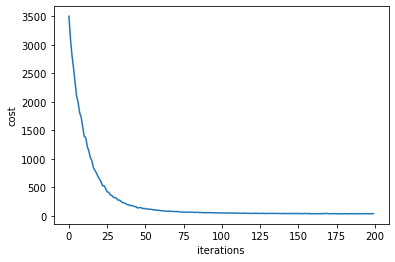

In [14]:
optimizer = FirstOrderNNPolicyOptimizer(params)
optimizer.iterate()
optimizer.plot_iterations()


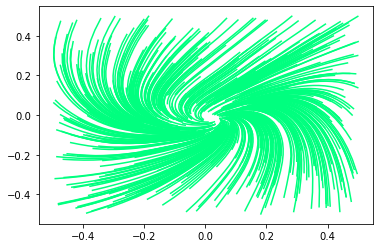

In [17]:
x0_batch = optimizer.sample_initial_state_batch()
zero_noise_trj = torch.zeros(params.batch_size, params.T, 2)
x_trj, u_trj = optimizer.rollout_policy_batch(x0_batch, zero_noise_trj)
x_trj = x_trj.detach().numpy()

plt.figure()
for b in range(params.batch_size):
    plt.plot(x_trj[b,:,0], x_trj[b,:,1], 'springgreen')
plt.show()
plt.close()